In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys
import matplotlib.pyplot as plt
import dill

sys.path.append('/data/users/morton/git/icrpythonradiomics/machineLearning')
from featureSelection import featureSelection_correlation, featureSelection_groupName


In [2]:
# function to make group strings easier to read
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

In [3]:
# open clinical spreadsheet
clinicalSpreadsheet = '/Users/morton/Dicom Files/RADSARC_R/ClinicalData/Clinical data for analysis.xlsx'
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', engine='openpyxl')
dfClinical = dfClinical[['Anon Code', 'Grade', 'subtype']]

In [4]:
# open radiomics data
dfRad = pd.read_csv('/Users/morton/Dicom Files/RADSARC_R/XNAT/extractions/extractions__20220910_1006_allRegions/radiomicFeatures/radiomicFeatures.csv')
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostic')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# select the standard feature set from the whole lesion and the volume fraction features
featureSets = ['lesion_original', 'lesion_sarcomaFeature']
dfRad = dfRad.filter(regex='|'.join(featureSets) + '|StudyPatientName')
for featureSet in featureSets:
    dfRad.rename(lambda x:x.replace(featureSet+'_',''), axis=1, inplace=True)
    dfRad.rename(lambda x:x.replace(' ','_'), axis=1, inplace=True)

# this feature is (virtually) redundant given the low and high volume fractions - it's only the calcification that implies the 'virtually'
if 'mid_enhancingVolumeFraction' in dfRad.columns:
    dfRad.drop('mid_enhancingVolumeFraction', axis=1, inplace=True)

In [5]:
# merge clinical and radiomics data into single frame
df = dfClinical.merge(dfRad, left_on='Anon Code', right_on='StudyPatientName')
df.drop('Anon Code', axis=1, inplace=True)
df.drop('StudyPatientName', axis=1, inplace=True)
df.drop('Grade', axis=1, inplace=True)
target = 'subtype'

In [6]:
X = df.drop(target, axis=1)
y = df[target]

#correlationHierarchy = []
correlationHierarchy = ['VolumeFraction', 'shape', 'firstorder']

groupHierarchy = ['']
textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'
# groupHierarchy = ['VolumeFraction', 'shape', 'firstorder', textureStr, 
#                   'VolumeFraction|shape', 'VolumeFraction|firstorder', 'VolumeFraction|'+textureStr, 
#                   'shape|firstorder', 'shape|'+textureStr, 'firstorder|'+textureStr, '']
groupHierarchy = ['VolumeFraction|shape', 'VolumeFraction|shape|firstorder',
                  'shape', 'shape|firstorder', 'shape|firstorder|'+textureStr, '']

pipe = Pipeline([('correlationSelector', featureSelection_correlation(threshold=0.6, exact=False, featureGroupHierarchy=correlationHierarchy)),
                 ('groupSelector', featureSelection_groupName()),
                 ('scaler', StandardScaler()),
                 ('rf', RandomForestClassifier())])

p_grid = {"groupSelector__groupFilter": groupHierarchy}

In [7]:
experiments = {}
thresholds = np.round(np.arange(0.6,1.001,0.05),2)
cv_mean = []
cv_std = []
for threshold in thresholds:
    
    pipe.steps[0][1].threshold = threshold

    random_state = 42
    np.random.seed(random_state)

    inner_cv = StratifiedKFold(n_splits=5)
    model = GridSearchCV(estimator=pipe, param_grid=p_grid, cv=inner_cv, refit=True, verbose=0, scoring='roc_auc', n_jobs=-1)
    model.fit(X, y)

    print('Threshold = ' + str(threshold))
    print(groupStrsDisp(model.best_estimator_.steps[1][1].groupFilter))
    
    # set to 1 ready for using n_jobs = -1 for cross validation
    model.n_jobs = 1

    n_splits = 10
    n_repeats = 2
    validation = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    # supress warnings for cross_validate
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    #
    cv_result = cross_validate(model, X, y, cv=validation, scoring='roc_auc', return_estimator=True, n_jobs=-1)
    #
    warnings.simplefilter('default')
    os.environ["PYTHONWARNINGS"] = 'default'

    experiments[str(threshold)] = {'model':copy.deepcopy(model), 'cv_result':copy.deepcopy(cv_result)}
    
    cv_mean.append(np.round(np.mean(cv_result['test_score']),3))
    cv_std.append(np.round(np.std(cv_result['test_score']),4))
    
    print('AUROC = ' + str(cv_mean[-1]) + ' \u00B1 ' + str(cv_std[-1]) + '\n')


Threshold = 0.6
VolumeFraction|shape|firstorder
AUROC = 0.876 ± 0.1036

Threshold = 0.65
VolumeFraction|shape|firstorder
AUROC = 0.872 ± 0.108

Threshold = 0.7
shape|firstorder|texture
AUROC = 0.889 ± 0.1061

Threshold = 0.75
VolumeFraction|shape|firstorder
AUROC = 0.926 ± 0.0577

Threshold = 0.8
VolumeFraction|shape|firstorder
AUROC = 0.919 ± 0.0629

Threshold = 0.85
VolumeFraction|shape|firstorder
AUROC = 0.92 ± 0.0595

Threshold = 0.9
all
AUROC = 0.93 ± 0.0539

Threshold = 0.95
shape|firstorder|texture
AUROC = 0.926 ± 0.057

Threshold = 1.0
all
AUROC = 0.921 ± 0.0627



In [8]:
# uncomment whichever is needed

##dill.dump_session('/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/GroupSelection_SarcomaFeatures_evaluateCorrelationThrehold/fittedModels.pkl')
##dill.load_session('/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/GroupSelectionBasicFeatures_evaluateCorrelationThrehold/fittedModels.pkl')

In [9]:
colNames = groupStrsDisp(groupHierarchy)
colNames.insert(0, 'threshold')
groupFrequencyDf = pd.DataFrame(columns=colNames)

for threshStr, result in experiments.items():
    cv_result = result['cv_result']
    group_cv_counts = {}
    group_cv = [groupStrsDisp(x.best_estimator_.steps[1][1].groupFilter) for x in cv_result['estimator']]
    groupCounts = [0]*len(groupHierarchy)
    for n, group in enumerate(groupStrsDisp(groupHierarchy)):
        groupCounts[n] = len([x for x in group_cv if x==group])
    groupCounts = [x/np.sum(groupCounts) for x in groupCounts]
    groupCounts.insert(0, float(threshStr))
    groupFrequencyDf = groupFrequencyDf.append(pd.DataFrame(data=[groupCounts], columns=colNames))
groupFrequencyDf = groupFrequencyDf.reset_index(drop=True)
groupFrequencyDf

,threshold,VolumeFraction|shape,VolumeFraction|shape|firstorder,shape,shape|firstorder,shape|firstorder|texture,all
0,0.60,0.10,0.65,0.0,0.05,0.00,0.20
1,0.65,0.05,0.50,0.0,0.10,0.00,0.35
2,0.70,0.05,0.45,0.0,0.15,0.15,0.20
3,0.75,0.00,0.60,0.0,0.05,0.05,0.30
4,0.80,0.00,0.40,0.0,0.00,0.05,0.55
5,0.85,0.00,0.55,0.0,0.00,0.15,0.30
6,0.90,0.00,0.25,0.0,0.05,0.15,0.55
7,0.95,0.00,0.15,0.0,0.05,0.40,0.40
8,1.00,0.00,0.15,0.0,0.05,0.35,0.45


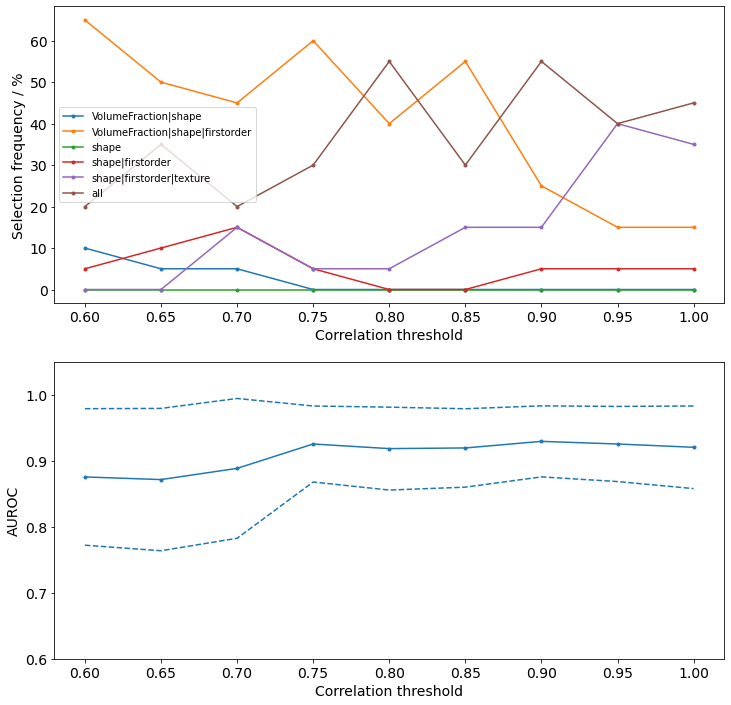

In [10]:
plt.rcParams['font.size'] = '14'
f,a = plt.subplots(2,1, figsize=(12,12))
for group in groupStrsDisp(groupHierarchy):
    a[0].plot(groupFrequencyDf['threshold'], 100*groupFrequencyDf[group], label=group, marker='.')
a[0].legend(fontsize=10)
a[0].set_xlabel('Correlation threshold')
a[0].set_ylabel('Selection frequency / %')

a[1].plot(thresholds, cv_mean, marker='.')
a[1].plot(thresholds, np.array(cv_mean) + np.array(cv_std), linestyle='--', color='C0')
a[1].plot(thresholds, np.array(cv_mean) - np.array(cv_std), linestyle='--', color='C0')
a[1].set_ylim([0.6, 1.05])
a[1].set_xlabel('Correlation threshold')
a[1].set_ylabel('AUROC')

plt.show()

In [11]:
# experiments.keys()

In [12]:
# get the experiment with threshold = 0.8

thresholdStr = '0.8'
model = experiments[thresholdStr]['model']
cv_result = experiments[thresholdStr]['cv_result']

In [13]:
print('AUROC (CV) = ' + str(np.round(np.mean(cv_result['test_score']),5)))

AUROC (CV) = 0.91875


In [14]:
# from fit to all data get the best feature group combination
groupStrsDisp(model.best_estimator_.steps[1][1].groupFilter)

'VolumeFraction|shape|firstorder'

In [15]:
# calculate net benefit for DCA
def calculate_net_benefit_score(y_true, y_pred, pt=0):
    _, fp, _, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    net_benefit = (tp - fp * (pt / (1 - pt))) / len(y_true)
    return net_benefit

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        # y_pred_label = y_pred_score
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp - fp * (thresh / (1 - thresh))) / n
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp - tn * (thresh / (1 - thresh))) / total
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

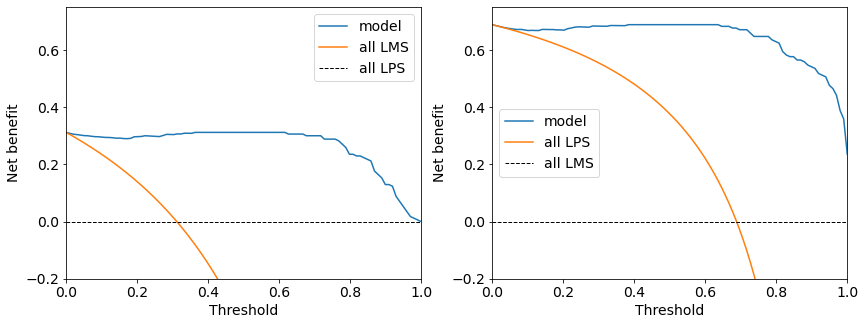

In [16]:
thresholdsDCA = np.linspace(1e-6,1-1e-6,100)

y_pred_score_LMS = model.predict_proba(X)[:,0]
net_benefit_model_LMS = calculate_net_benefit_model(thresholdsDCA, y_pred_score_LMS, np.array(y=='LMS').astype(int))
net_benefit_all_LMS = calculate_net_benefit_all(thresholdsDCA, np.array(y=='LMS').astype(int))

y_pred_score_LPS = model.predict_proba(X)[:,1]
net_benefit_model_LPS = calculate_net_benefit_model(thresholdsDCA, y_pred_score_LPS, np.array(y=='LPS').astype(int))
net_benefit_all_LPS = calculate_net_benefit_all(thresholdsDCA, np.array(y=='LPS').astype(int))

f,a = plt.subplots(1,2, figsize=(14,5))

a[0].plot(thresholdsDCA, net_benefit_model_LMS, label='model')
a[0].plot(thresholdsDCA, net_benefit_all_LMS, label='all LMS')
a[0].plot(thresholdsDCA, np.zeros(len(thresholdsDCA)), linewidth=1, linestyle='--', color='k', label='all LPS')
a[0].legend()
a[0].set_xlim([0, 1])
a[0].set_ylim([-0.2, 0.75])
a[0].set_xlabel('Threshold')
a[0].set_ylabel('Net benefit')

a[1].plot(thresholdsDCA, net_benefit_model_LPS, label='model')
a[1].plot(thresholdsDCA, net_benefit_all_LPS, label='all LPS')
a[1].plot(thresholdsDCA, np.zeros(len(thresholdsDCA)), linewidth=1, linestyle='--', color='k', label='all LMS')
a[1].legend()
a[1].set_xlim([0, 1])
a[1].set_ylim([-0.2, 0.75])
a[1].set_xlabel('Threshold')
a[1].set_ylabel('Net benefit')

plt.show()

In [17]:
fi = np.zeros(X.shape[1])
mask0 = copy.deepcopy(model.best_estimator_.steps[0][1].mask_)
mask1 = model.best_estimator_.steps[1][1].colMask_
mask0[mask0] = mask1
fi[mask0] = model.best_estimator_._final_estimator.feature_importances_
feat_imp = pd.DataFrame(columns=['Feature'], data = X.columns)
feat_imp['Importance'] = fi
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)
feat_imp = feat_imp.loc[feat_imp.Importance>0,:]
feat_imp.style.hide_index()

Feature,Importance
firstorder_90Percentile,0.144539
firstorder_Minimum,0.123618
low_enhancingVolumeFraction,0.119228
high_enhancingVolumeFraction,0.103496
shape_Sphericity,0.079221
shape_SurfaceVolumeRatio,0.069938
firstorder_RootMeanSquared,0.064881
firstorder_Skewness,0.060268
firstorder_Maximum,0.054804
shape_Flatness,0.054656
